In [ ]:
!pip install wordcloud

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
# Load dataset
data = pd.read_csv('Job opportunities.csv')

#**Data Preparation**

In [ ]:
# Pembersihan data
data.dropna(subset=['Required Skills', 'Job Title'], inplace=True)

###One-Hot Encoding atau Label Encoding.

In [ ]:
# Tokenisasi keterampilan
data['Required Skills'] = data['Required Skills'].apply(lambda x:[skill.lower() for skill in x.split(', ')])

# Flatten the list of skills for Tokenizer
all_skills = [skill for sublist in data['Required Skills'] for skill in sublist]

# Menggunakan Tokenizer untuk keterampilan
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(all_skills)

# Mengonversi keterampilan menjadi array one-hot
X_skills = tokenizer.texts_to_matrix([' '.join(skills) for skills in data['Required Skills']], mode='binary')

In [ ]:
# Encoding label pekerjaan
job_titles = data['Job Title'].unique()
y_titles = {title: index for index, title in enumerate(job_titles)}
y_encoded = np.array([y_titles[title] for title in data['Job Title']])


##Data Splitting

###Training, Validation, Test Sets

In [ ]:
# Pembagian data
X_train, X_test, y_train, y_test = train_test_split(X_skills, y_encoded, test_size=0.2, random_state=42)

#**Model Selection**

##Models

In [ ]:
# Membangun model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),  # Baru ditambahkan
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),  # Baru ditambahkan
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(job_titles), activation='softmax')  # Jumlah kelas sesuai dengan jumlah judul pekerjaan
])

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#**Training and Evaluation**

##Training Models

In [ ]:
# Menggunakan EarlyStopping
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      """
      Fungsi untuk menghentikan pelatihan model secara otomatis saat kriteria tertentu tercapai.

      Fungsi ini dipanggil pada akhir setiap epoch selama pelatihan. Jika akurasi pelatihan (accuracy)
      mencapai nilai minimum yang diinginkan (0.9) dan akurasi validasi (val_accuracy) mencapai nilai
      minimum yang diinginkan (0.8), maka pelatihan dihentikan untuk menghemat waktu dan menghindari
      overfitting.

      Args:
          epoch (int): Nomor epoch yang sedang dijalankan.
          logs (dict): Dictionary yang berisi metrik pelatihan dan validasi pada epoch tersebut,
                      seperti 'accuracy' dan 'val_accuracy'.
      """
      if logs['accuracy'] >= 0.9 and logs['val_accuracy'] >= 0.8:
          self.model.stop_training = True
          print("\nReached 90% train accuracy and 80% validation accuracy, stopping training!")


In [ ]:
# Melatih model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStoppingCallback()]
    )

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.0196 - loss: 5.4130 - val_accuracy: 0.1017 - val_loss: 4.2769
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0399 - loss: 4.6219 - val_accuracy: 0.2373 - val_loss: 4.2142
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1903 - loss: 3.5124 - val_accuracy: 0.2542 - val_loss: 4.1446
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3133 - loss: 2.9611 - val_accuracy: 0.2712 - val_loss: 4.0778
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4232 - loss: 2.3238 - val_accuracy: 0.2881 - val_loss: 4.0119
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5797 - loss: 1.9270 - val_accuracy: 0.3051 - val_loss: 3.9479
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6778 - loss: 1.5726 - val_accuracy: 0.3051 - val_loss: 3.8858
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6936 - loss: 1.4236 - val_accuracy: 0.3729 - val_loss: 3.8261


##manual testing

In [ ]:
def predict_top_jobs(model, tokenizer, skills, label_map, top_n=3):
    """
    Fungsi untuk memprediksi beberapa job title yang paling relevan berdasarkan keterampilan.

    Args:
        model (tf.keras.Model): Model terlatih untuk klasifikasi pekerjaan.
        tokenizer (tf.keras.preprocessing.text.Tokenizer): Tokenizer yang digunakan untuk memproses keterampilan.
        skills (list of str): Daftar keterampilan dalam bentuk string.
        label_map (dict): Mapping dari indeks ke judul pekerjaan.
        top_n (int): Jumlah job title yang ingin diprediksi (default: 3).

    Returns:
        list of tuple: Daftar top_n job title dan probabilitasnya, dalam format (job_title, probability).
    """
    # Tokenisasi keterampilan dan konversi ke representasi numerik
    skills_encoded = tokenizer.texts_to_matrix([' '.join(skills)], mode='binary')

    # Melakukan prediksi
    predictions = model.predict(skills_encoded)[0]  # Ambil hasil prediksi untuk input pertama

    # Ambil indeks dan probabilitas dari prediksi tertinggi
    top_indices = np.argsort(predictions)[::-1][:top_n]  # Urutkan secara descending dan ambil top_n
    top_jobs = [(label_map[idx], predictions[idx]) for idx in top_indices]

    return top_jobs


In [ ]:
# Mapping dari indeks ke nama pekerjaan
label_map = {v: k for k, v in y_titles.items()}  # Membalikkan dictionary untuk memetakan indeks ke pekerjaan

# Contoh keterampilan untuk prediksi
sample_skills = ['cybersecurity', 'python', 'c++', 'cisco']  # Input keterampilan

# Panggil fungsi prediksi untuk 3 job title teratas
top_jobs = predict_top_jobs(model, tokenizer, sample_skills, label_map, top_n=3)

# Tampilkan hasil prediksi
print("Top 3 Predicted Job Titles:")
for i, (job_title, probability) in enumerate(top_jobs, start=1):
    print(f"{i}. {job_title} (Probability: {probability:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Top 3 Predicted Job Titles:
1. Cybersecurity Analyst (Probability: 0.08)
2. Network Engineer (Probability: 0.04)
3. Software Developer (Probability: 0.04)


##Evaluation Metrics

In [ ]:
# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8465 - loss: 1.6281 
Test Accuracy: 0.85


# **visualisasi**

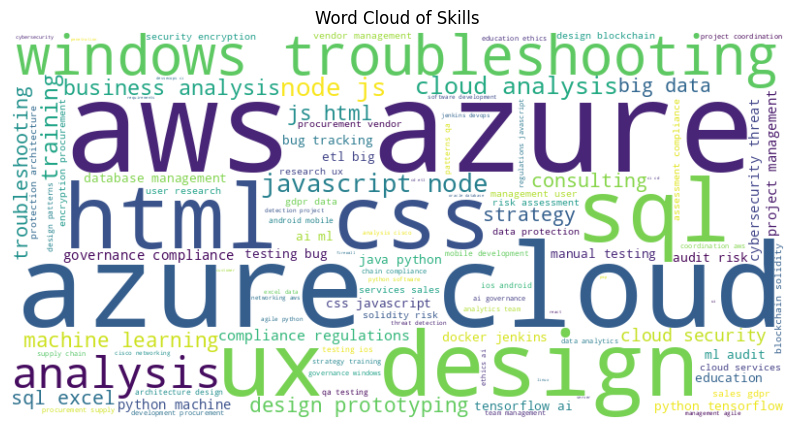

In [ ]:
# Fungsi untuk membuat word cloud dari data keterampilan
def create_skill_wordcloud(data):
    """
    Fungsi untuk membuat Word Cloud berdasarkan keterampilan yang ada di dataset.

    Args:
        data: DataFrame yang digunakan untuk pelatihan.
    """
    # Menggabungkan semua keterampilan menjadi satu string
    all_skills = ' '.join([skill for sublist in data['Required Skills'] for skill in sublist])

    # Membuat word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_skills)

    # Menampilkan word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Matikan axis
    plt.title('Word Cloud of Skills')
    plt.show()

# Panggil fungsi untuk membuat Word Cloud
create_skill_wordcloud(data)


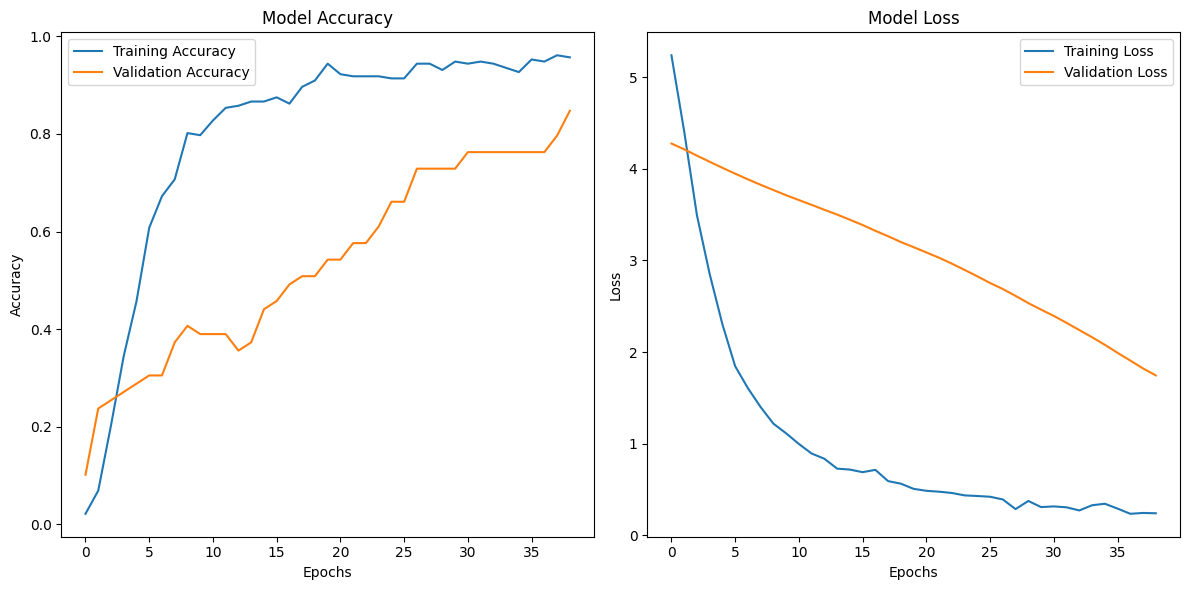

In [ ]:
# Visualisasi Performa Model
def plot_training_history(history):
    """
    Visualisasi akurasi dan loss selama pelatihan.

    Args:
        history: Objek History dari hasil pelatihan model.
    """
    plt.figure(figsize=(12, 6))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Panggil fungsi visualisasi
plot_training_history(history)


##Confusion Matrix

#**Model Deployment**

In [ ]:
import json

# Simpan tokenizer dan label ke dalam satu file JSON
tokenizer_json = tokenizer.to_json()
tokenizer_data = json.loads(tokenizer_json)
tokenizer_data['job_titles'] = y_titles  # Tambahkan mapping judul pekerjaan

with open('tokenizer_and_labels.json', 'w') as f:
    json.dump(tokenizer_data, f, indent=4)

print("Tokenizer dan label pekerjaan berhasil disimpan dalam tokenizer_and_labels.json.")


Tokenizer dan label pekerjaan berhasil disimpan dalam tokenizer_and_labels.json.


In [ ]:
# Simpan model Keras
model.save('model_nextStep.h5')

# # Simpan tokenizer untuk keterampilan
# tokenizer_json = tokenizer.to_json()
# with open('tokenizer.json', 'w') as f:
#     f.write(tokenizer_json)
#     print("Label berhasil disimpan.")

# Konversi model Keras ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open('nextStep.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi dan disimpan sebagai nextStep.tflite")

Saved artifact at '/tmp/tmp1lmzklee'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 120), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 74), dtype=tf.float32, name=None)
Captures:
  139465510358528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139465510356240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139465510363456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139465510362752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139465510361520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139465510363104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139465510364864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139465510365744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139465510366800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139465510368560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139465510366624: Tens